### Utility file
Various functions to process the initial bed data

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from motif_utils import seq2kmer
from scipy.stats import norm
import collections
import operator

### Gene file preprocessing

In [6]:
whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'

In [7]:
# function for preprocess the whole gene data and produce chromosome-wise gene lists
# each element is dataframe

def whGene2GLChr(whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'):
    g_fn=whole_gene_file
    g_df_raw=pd.read_csv(g_fn, sep='\t', lineterminator='\n', header=None, low_memory=False)
    g_df_int=g_df_raw.rename(columns={0:"chromosome",1:"TxStart",2:"TxEnd",3:"name",4:"unk0",
                                  5:'strand', 6:'cdsStart', 7:'cdsEnd',8:"unk1",9:"exonCount",
                                  10:"unk2",11:"unk3"})
    g_df=g_df_int[["chromosome","TxStart","TxEnd","name"]]
    
    # Remove other than regular chromosomes
    chr_lst=['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10',
             'chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19',
             'chr20','chr21','chr22','chrX','chrY']
    g_df=g_df.loc[g_df["chromosome"].isin(chr_lst)]
    
    # Create a list of chromosome-wise dataframe 
    g_df_chr_lst=[]
    for num in range(len(chr_lst)):
        chr_num=chr_lst[num]
        g_chr_df='g_'+chr_num
        locals()[g_chr_df]=g_df[g_df["chromosome"]==chr_num]
        g_chr_df=locals()[g_chr_df]
        g_chr_df=g_chr_df.sort_values("TxStart")
        g_df_chr_lst.append(g_chr_df)
        
    return g_df_chr_lst

### Genome statistics

In [4]:
chr_path='../database/hg19/genome_per_chr/'
chr_list=[os.path.join(chr_path, file) for file in sorted(os.listdir(chr_path))]
chr1=chr_list[0]

In [6]:
def chrNdist(chr_file=chr1):
    """
    input: divided genome by chromosome (without any index, only genome)
    output: dataframe of [start, end] position of "N" in the genome sequence
    """
    with open(chr_file) as infile:
        all_n_line="N"*50    # python reads text line by 50 characters
        all_n_index=[]
        all_n_start=[1]
        all_n_end=[]

        for i, line in enumerate(infile):
            if all_n_line in line:
                all_n_index.append(i)    # all_n_index is a list of N

        for i, num in enumerate(all_n_index):   
            if i==0:        
                pre_num=num
            elif num !=pre_num+1:
                all_n_start.append(num)
            pre_num=num   
        for i, num in enumerate(all_n_index):   
            if i==0:        
                pre_num=num
            elif num !=pre_num+1:
                all_n_end.append(pre_num+1)
            pre_num=num
        all_n_end.append(all_n_index[-1]+1)

        assert len(all_n_start)==len(all_n_end)
        
        n_dist_df=pd.DataFrame({"start":all_n_start,"end":all_n_end, 
                                "count":[e-s+1 for s,e in zip(all_n_start,all_n_end)]},
                               columns=["start","end","count"])
        fig=plt.figure(figsize=(8,4))
        plt.hist(all_n_index, 50, facecolor='teal', alpha=0.75)
        plt.xlabel("Position")
        plt.ylabel("number of 'N' lines")
        plt.show()
        return n_dist_df

### Chromatin state preprocessing
#### Preparing the .bed file list

In [8]:
# file name reader
# make a list of all the filename

path='../database/bed/unzipped/'
bed_files=os.listdir(path)

pickle_path='../database/cell_pickle'
pickle_files=os.listdir(pickle_path)

def file_list_maker(path, files):
    all_files=[]
    for file in files:
        file_path=os.path.join(path,file)
        all_files.append(file_path)
    return all_files

all_files=file_list_maker(path, bed_files)
all_cell_pickles=file_list_maker(pickle_path, pickle_files)

In [9]:
all_files[0]

'../database/bed/unzipped/E001_15_coreMarks_stateno.bed'

In [10]:
all_cell_pickles[0]

'../database/cell_pickle/df_cell001.pkl'

In [11]:
# test file
# test_filename='../database/bed/unzipped/E017_15_coreMarks_stateno.bed'

In [12]:
state_dict={1:"A", 2:"B", 3:"C", 4:"D", 5:"E",6:"F",7:"G",8:"H" ,
                9:"I" ,10:"J",11:"K", 12:"L", 13:"M", 14:"N", 15:"O"}

In [13]:
css_name=['TssA','TssAFlnk','TxFlnk','Tx','TxWk','EnhG','Enh','ZNF/Rpts',
          'Het','TssBiv','BivFlnk','EnhBiv','ReprPC','ReprPcWk','Quies']

In [14]:
css_dict=dict(zip(list(state_dict.values()), css_name))  # css_dict={"A":"TssA", "B":"TssAFlnk", ... }

In [15]:
# color dict update using the info from https://egg2.wustl.edu/roadmap/web_portal/chr_state_learning.html
# 18th May 2022

css_color_dict={'TssA':(255,0,0), # Red
                'TssAFlnk': (255,69,0), # OrangeRed
                'TxFlnk': (50,205,50), # LimeGreen
                'Tx': (0,128,0), # Green
                'TxWk': (0,100,0), # DarkGreen
                'EnhG': (194,225,5), # GreenYellow 
                'Enh': (255,255,0),# Yellow
                'ZNF/Rpts': (102,205,170), # Medium Aquamarine
                'Het': (138,145,208), # PaleTurquoise
                'TssBiv': (205,92,92), # IndianRed
                'BivFlnk': (233,150,122), # DarkSalmon
                'EnhBiv': (189,183,107), # DarkKhaki
                'ReprPC': (128,128,128), # Silver
                'ReprPCWk': (192,192,192), # Gainsboro
                'Quies': (240, 240, 240)}  # White -> bright gray 

# css_color_dict={'TssA':(219, 57, 50), 
#                 'TssAFlnk': (222, 87, 54), 
#                 'TxFlnk': (107, 187, 87),
#                 'Tx': (57, 124, 72), 
#                 'TxWk': (48, 98, 58), 
#                 'EnhG': (197, 213, 80), 
#                 'Enh': (245, 196, 98),
#                 'ZNF/Rpts': (129, 194, 169), 
#                 'Het': (137,143,189), 
#                 'TssBiv': (192, 98, 95), 
#                 'BivFlnk': (223, 156, 127), 
#                 'EnhBiv': (188, 182, 115), 
#                 'ReprPC': (147, 149, 153),
#                 'ReprPCWk': (200, 202, 203), 
#                 'Quies': (240, 240, 240)}  # 255,255,255 was white -> bright gray 

In [16]:
def colors2color_dec(css_color_dict):
    colors=list(css_color_dict.values())
    color_dec_list=[]
    for color in colors:
        color_dec=tuple(rgb_elm/255 for rgb_elm in color)
        color_dec_list.append(color_dec)        
    return color_dec_list

In [17]:
state_col_dict=dict(zip(list(state_dict.values()),colors2color_dec(css_color_dict)))

In [18]:
state_col_255_dict=dict(zip(list(state_dict.values()),list(css_color_dict.values())))

In [19]:
css_name_col_dict=dict(zip(css_name,state_col_dict.values()))

#### Function to convert RGB into decimal RGB

#### Function to create pickle file (dataframe, expanded version) for an individual cell

In [20]:
# create a pickle for a cell-wise dataframe

def total_df2pickle(total_df_list):
    for num, df_cell in enumerate(tqdm.notebook.tqdm(total_df_list)):
        path="../database/cell_pickle/"
        if num+1 < 10:
            file_name=path+"df_cell"+"00"+str(num+1)+".pkl"
            df_cell_pickled=df_cell.to_pickle(file_name)
        elif num+1 < 100:
            file_name=path+"df_cell"+"0"+str(num+1)+".pkl"
            df_cell_pickled=df_cell.to_pickle(file_name)
        else:
            file_name=path+"df_cell"+str(num+1)+".pkl"
            df_cell_pickled=df_cell.to_pickle(file_name)


#### Functions to make .bed to dataframe

In [21]:
# create dataframe from bed file
# bed file here means: EXXX_15_coreMarks_stateno.bed

def bed2df_as_is(filename):    
    
    """Create dataframe from the .bed file, as is.
    Dataframe contains following columns:
    chromosome |  start |  end  | state """
    
    df_raw=pd.read_csv(filename, sep='\t', lineterminator='\n', header=None, low_memory=False)
    df=df_raw.rename(columns={0:"chromosome",1:"start",2:"end",3:"state"})
    df=df[:-1]
    df["start"]=pd.to_numeric(df["start"])
    df["end"]=pd.to_numeric(df["end"])
    
    return df

In [22]:
def bed2df_expanded(filename):
    
    """Create an expanded dataframe from the .bed file.
    Dataframe contains following columns:
    chromosome |  start |  end  | state | length | unit | state_seq | state_seq_full"""
   
    df_raw=pd.read_csv(filename, sep='\t', lineterminator='\n', header=None, low_memory=False)
    df=df_raw.rename(columns={0:"chromosome",1:"start",2:"end",3:"state"})
    df=df[:-1]
    df["start"]=pd.to_numeric(df["start"])
    df["end"]=pd.to_numeric(df["end"])
    df["state"]=pd.to_numeric(df["state"])
    df["length"]=df["end"]-df["start"]
    df["unit"]=(df["length"]/200).astype(int)  # chromatin state is annotated every 200 bp (18th May 2022)
               
    df["state_seq"]=df["state"].map(state_dict)
    df["state_seq_full"]=df["unit"]*df["state_seq"]
    
    return df 

In [23]:
def total_df_maker(all_files):
    
    """Create a list of dataframe from a list of bed files.
    This function utilizes the function named 'bed2df_expanded.'"""
    
    total_df=[]
    for filename in all_files:
        df=bed2df_expanded(filename)
        total_df.append(df)
    return total_df

#### Functions for analyzing an individual dataframe

CSS here refers Chromatin state sequence

In [24]:
def numchr(df):
    assert "chromosome" in df.columns, "Check your df has the column named 'chromosome'"
    return df["chromosome"].nunique()    

In [25]:
# create a large piece of string of the whole state_seq_full 
# CSS: chromatin-state sequence

def df2css_allchr(df):
    
    """Create a large piece of string of the whole state_seq_full 
    This function generates a string from the entire chromosomes"""
    
    state_seq_full_list=df["state_seq_full"].tolist()
    state_seq_full_to_str=''.join([elm for elm in state_seq_full_list ])
    return state_seq_full_to_str

#### Create CSS chromosome-wise

In [26]:
# first, learn where one chromosome ends in the df
# this is just a prerequisite function for df2css_chr

def df2chr_index(df):
    
    """Create a list of smaller piece of string of the state_seq_full per chromosome
    This function generates a list of chromatin state sequence strings chromosome-wise"""
    
    total_row=len(df)
    chr_len=[]
    chr_check=[]
    chr_index=[]

    for i in range(total_row):
        if (df["start"].iloc[i]==0) & (i >0):
            chr_len.append(df["end"].iloc[i-1]) # chr_len stores the end position of each chromosome
            chr_check.append(df["start"].iloc[i]) # for assertion : later check chr_check are all zero
            chr_index.append(i-1) # the index (row number)

    end_len=df["end"].iloc[-1] # add the final end position
    end_index=total_row-1 # add the final end index (row number)
 
    chr_len.append(end_len)
    chr_index.append(end_index)

    assert len(chr_len)==df["chromosome"].nunique() #assert the length of the list corresponds to no. of chromosome
    assert len(chr_index)==df["chromosome"].nunique()
    
    return chr_index

#### Create df cut by each chromosome

In [27]:
def df2chr_df(df):
   
    """Create a list of dataframes, each of which containing 
    the the whole expanded type of dataframe per chromosome"""
    
    start=0
    df_chr_list=[]
    chr_index=df2chr_index(df)
    
    for index in chr_index:
        df_chr=df[start:index+1] # note that python [i:j] means from i to j-1
        chr_name=df["chromosome"].iloc[start] # string, such as chr1, chr2, ...
        df_name='df_'+chr_name  # the chromosome-wise data stored like df_chr1, df_chr2, ...
        locals()[df_name]=df_chr # make a string into a variable name
        df_chr_list.append(df_chr)
        start=index+1
    
    return df_chr_list   # elm is the df of each chromosome

#### Create CSS chromosome-wise, string only

In [28]:
# create a list of dataframes, each of which contains the name of chromosome and chromosome-wise string of state_seq_full
# This is prerequisite function for df2css_chr_string

def df2css_chr(df):
   
    """Create a list of dataframes, each of which containing 
    the chromosome name and the state_seq_full per chromosome (2 columns)"""
    
    start=0
    df2col_chr_list=[]
    chr_index=df2chr_index(df)
    
    for index in chr_index:
        df_chr=df[["chromosome","state_seq_full"]][start:index+1] # note that python [i:j] means from i to j-1
        chr_name=df["chromosome"].iloc[start] # string, such as chr1, chr2, ...
        df2col_name='df2col_'+chr_name  # the chromosome-wise data stored like df2col_chr1, df2col_chr2, ...
        locals()[df2col_name]=df_chr # make a string into a variable name
        df2col_chr_list.append(df_chr)
        start=index+1
    
    return df2col_chr_list    

In [29]:
def df2css_chr_str(df):
    
    """Create a list of strings which is the state_seq_full, all-connected per chromosome"""
    
    chr_index=df2chr_index(df)  
    chr_index_num=len(chr_index) 

    df2col_chr_list=df2css_chr(df)  # contains a list of df: chromosome name, state_seq_full (2-column datafame)
    chr_css_list=[]

    for num in range(chr_index_num): 
        css_full_list=df2col_chr_list[num]["state_seq_full"].tolist()  # extract the state_seq_full only and make it a list
        css_full_to_str=''.join([elm for elm in css_full_list]) # make it a long string of all-connected state_seq_full (chromosome-wise)
        chr_css_list.append(css_full_to_str)
    return chr_css_list

#### make a long string of the css (not using unit, but the real length)
* ChrM is removed
* chromosome-wise list
* real length

In [30]:
# make a long string of the css (not using unit, but the real length)

def df2longcss(df):
    df_lst_chr=df2chr_df(df)
    # remove the microchondria DNA from df_lst_chr
    if df_lst_chr[-3]["chromosome"].iloc[0]=="chrM":
        del df_lst_chr[-3]
        assert df_lst_chr[-3]["chromosome"].iloc[0]=="chr22"
    else:   
        assert df_lst_chr[-3]["chromosome"].iloc[0]=="chr22"
    
    all_css=[]
    for i in range(len(df_lst_chr)):
        df_chr=df_lst_chr[i]
        css_chr=''
        for j in range(len(df_chr)):
            css_chr+=df_chr["length"].iloc[j]*df_chr["state_seq"].iloc[j]
        all_css.append(css_chr)  
    return all_css

In [31]:
# make a long string of the css (unit length, not the real length)

def df2unitcss(df):
    df_lst_chr=df2chr_df(df)
    # remove the microchondria DNA from df_lst_chr
    if df_lst_chr[-3]["chromosome"].iloc[0]=="chrM":
        del df_lst_chr[-3]
        assert df_lst_chr[-3]["chromosome"].iloc[0]=="chr22"
    else:   
        assert df_lst_chr[-3]["chromosome"].iloc[0]=="chr22"
    
    all_unit_css=[]
    for i in range(len(df_lst_chr)):
        df_chr=df_lst_chr[i]
        css_chr=''
        for j in range(len(df_chr)):
            css_chr+=df_chr["unit"].iloc[j]*df_chr["state_seq"].iloc[j]
        all_unit_css.append(css_chr)  
    return all_unit_css

### Statistics
* With 15th state
1. State distribution on genome across all the cell types

In [32]:
def prop_data2df(path='../database/conserv_overlap/'):
    file_list=[os.path.join(path, file) for file in os.listdir(path)]
    
    temp_df=pd.read_csv(file_list[0],sep='\t', lineterminator='\n')
    init_col=pd.DataFrame(temp_df["state (Emission order)"])
    init_col=init_col.rename(columns={"state (Emission order)":"state"})
    for file in file_list:
        file_name=file.split('/')[3]
        sample_name=file_name.split('_')[0]

        prop_data=pd.read_csv(file, sep='\t', lineterminator='\n')
        prop=prop_data["Genome %"]
        temp_df=pd.concat([init_col,prop], axis=1)
        temp_df=temp_df.rename(columns={"Genome %":str(sample_name)})
        init_col=temp_df
    
    # show the result df (first col=state, other col=samples)
    temp_df.drop(temp_df.tail(1).index, inplace=True) # remove the last row (100%)
    
    # transposed and trimmed df (col+1=state no. row=samples)
    trans_df=temp_df.T
    trans_df.drop(trans_df.head(1).index, inplace=True)
    trans_df.columns=temp_df["state"].to_list()
    
    state_list=temp_df["state"].to_list()
    
    ################### create a plot for genome proportion across cell types
    fig=plt.figure(figsize=(9,5))
    ax=fig.add_subplot(111)
    for i in range(len(state_list)):
        state=list(css_color_dict.keys())[i]
        state_as_colname=list(trans_df.columns)[i]

        color=tuple([elm/255 for elm in css_color_dict[state]])

        bp=ax.boxplot(trans_df.iloc[:,i],widths=0.65,positions = [i+1], notch=True,patch_artist=True, 
                     boxprops=dict(facecolor=color, color="gray"),whiskerprops=dict(color="gray", linewidth=2),
                     medianprops=dict(color=color, linewidth=2),
                     capprops=dict(color="gray", linewidth=2),
                     flierprops=dict(markeredgecolor=color, markeredgewidth=1.5))
    plt.xticks(list(range(1,16)),list(trans_df.columns))
    plt.xlabel("Chromatin state")
    plt.ylabel("Genome [%]\n across Different Cell Types")
    fig.autofmt_xdate(rotation=45)
    plt.show()
    ###################
    
    return temp_df, trans_df

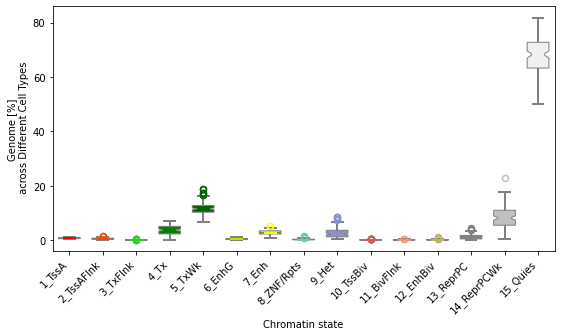

In [33]:
temp_df, trans_df=prop_data2df(path='../database/conserv_overlap/')

### Cutting the telomere: where to cut?

In [7]:
# index list for O state in unit-length css sequence:
def UnitCSS_Q_Dist(df, chr_no=1):
    all_unit_css=df2unitcss(df)
    chr_unit_css=all_unit_css[chr_no]
    q_index=[]
    for i,state in enumerate(chr_unit_css):
        if state=="O":
            q_index.append(i)
    fig=plt.figure(figsize=(8,4))
    plt.hist(q_index, 50, facecolor='orange', alpha=0.75)
    plt.xlabel("Position")
    plt.ylabel("number of 'O' state")
    plt.show()
    return q_index

#### Cut the chromatin states : genic area

In [34]:
def compGene2css(whole_gene_file,df):
    g_lst_chr=whGene2GLChr(whole_gene_file) # list of gene table df per chromosome
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(g_lst_chr)
    
    css_gene_lst_all=[]
    for i in range(total_chr):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=g_lst_chr[i] # gene df of i-th chromosome
        
        css_gene_lst_chr=[]
        for j in range(len(gene_df)):
            g_start=gene_df["TxStart"].iloc[j]-1  # python counts form 0
            g_end=gene_df["TxEnd"].iloc[j]+1      # python excludes the end
            
            css_gene=css[g_start:g_end]           # cut the gene area only
            css_gene_lst_chr.append(css_gene)     # store in the list
          
        css_gene_lst_all.append(css_gene_lst_chr)  # list of list
    
    assert len(css_gene_lst_all)==total_chr
    return css_gene_lst_all

* css_gene_lst_all : list of list that css for genic region per chromosome

#### Count the number of 15th states in genic, non-genic region

In [35]:
# for cell-wise count : how many 15th-including genes are there per cell

def QnonQforCell(all_files=all_files,whole_gene_file=whole_gene_file):
    total_cells=len(all_files)
    
    q_cnt_lst=[]
    not_q_cnt_lst=[]
    for i in range(total_cells):
        cell_path=all_files[i]
        df=bed2df_expanded(cell_path)
        css_gene_lst_all=compGene2css(whole_gene_file,df)
        
        q_cnt=0
        not_q_cnt=0
        for j in range(len(css_gene_lst_all)):
            css_gene_lst=css_gene_lst_all[j]
            for k in range(len(css_gene_lst)):
                css_gene=css_gene_lst[k]
                if "O" in css_gene:
                    q_cnt+=1
                else:
                    not_q_cnt+=1
        q_cnt_lst.append(q_cnt)
        not_q_cnt_lst.append(not_q_cnt)
    return q_cnt_lst, not_q_cnt_lst

In [53]:
# for chromosome-wise list of list -> flatten list

def QnonQforChr(all_files=all_files,whole_gene_file=whole_gene_file):
#     import itertools
    total_cells=len(all_files)
    
    q_cnt_lst_all=[]
    not_q_cnt_lst_all=[]
    for i in range(total_cells):
        cell_path=all_files[i]
        df=bed2df_expanded(cell_path)
        css_gene_lst_all=compGene2css(whole_gene_file,df)
        
        q_cnt_lst=[]
        not_q_cnt_lst=[]
        for j in range(len(css_gene_lst_all)):
            css_gene_lst=css_gene_lst_all[j]
            
            q_cnt=0
            not_q_cnt=0
            for k in range(len(css_gene_lst)):
                css_gene=css_gene_lst[k]
                if "O" in css_gene:
                    q_cnt+=1
                else:
                    not_q_cnt+=1
                    
            q_cnt_lst.append(q_cnt)
            not_q_cnt_lst.append(not_q_cnt)        
        q_cnt_lst_all.append(q_cnt_lst)
        not_q_cnt_lst_all.append(not_q_cnt_lst)

#     flatten the list of list and make it into list
    q_cnt_lst_all=list(itertools.chain.from_iterable(q_cnt_lst_all))
    not_q_cnt_lst_all=list(itertools.chain.from_iterable(not_q_cnt_lst))
        
    return q_cnt_lst_all, not_q_cnt_lst_all

In [60]:
# draw a histogram type1 (group by data)
def QnonQforCellHistT1(q_cnt_lst, not_q_cnt_lst, bin_size=15):
    """Run this after executing QnonQforCell"""
    data_w=q_cnt_lst
    data_wo=not_q_cnt_lst

    mu_w, std_w=norm.fit(data_w)
    mu_wo, std_wo=norm.fit(data_wo)

    plt.hist(data_w, bins=bin_size, alpha=0.3, color="k")
    plt.hist(data_wo, bins=bin_size, alpha=0.5, color="r")

#     xmin_w, xmax_w=plt.xlim()
#     xmin_wo, xmax_wo=plt.xlim()

#     x_w = np.linspace(xmin_w, xmax_w, 100)
#     p_w = norm.pdf(x_w, mu_w, std)
#     x_wo = np.linspace(xmin_wo, xmax_wo, 100)
#     p_wo = norm.pdf(x_wo, mu_wo, std)

#     plt.plot(x_w, p_w, "r", linewidth=2)
#     plt.plot(x_wo, p_wo, "k", linewidth=2)

    title='Number of Genic region with/without Quiescent state'
    plt.title(title)
#     plt.legend("with Quiescent state","without Quiescent state")
    plt.xlabel("No. of Genes")
    plt.ylabel("Counts")
    plt.show()

In [59]:
# draw a histogram type2 (group by bin)
def QnonQforCellHistT2(q_cnt_lst, not_q_cnt_lst,bin_size):
    """Run this after executing QnonQforCell"""
    data_w=q_cnt_lst
    data_wo=not_q_cnt_lst

    mu_w, std_w=norm.fit(data_w)
    mu_wo, std_wo=norm.fit(data_wo)

    fig=plt.figure(figsize=(8,4))
    ax=fig.add_subplot(1,1,1)
    ax.hist([data_w,data_wo], bins=bin_size, alpha=0.5, color=["teal","orange"], label=["with Quiescent state","without Quiescent state"])

#     xmin_w, xmax_w=plt.xlim()
#     xmin_wo, xmax_wo=plt.xlim()

#     x_w = np.linspace(xmin_w, xmax_w, 100)
#     p_w = norm.pdf(x_w, mu_w, std)
#     x_wo = np.linspace(xmin_wo, xmax_wo, 100)
#     p_wo = norm.pdf(x_wo, mu_wo, std)

    ax.legend(loc="upper left")

#     plt.plot(x_w, p_w, "teal", linewidth=2)
#     plt.plot(x_wo, p_wo, "orange", linewidth=2)

    title='Number of Genic region with/without Quiescent state'
    plt.title(title)
    plt.legend()
    plt.xlabel("No. of Genes")
    plt.ylabel("Counts")
    plt.show()

In [ ]:
# generate thee lists: 15th state-including gene count, gene length, proportion of 15th state per gene
def cntQinGene(css_gene_lst_all):
    """run this after executing compGene2css(whole_gene_file,df)
       [Input]
       css_gene_lst_all : list of css list of each chromosome
       [Output]
       cnt_o_lst : list of Quiescent state counts list per chromosome
       gene_len_lst : list of gene length (in terms of chromatin state Anno.200bps) list per chromosome
       pro_o_lst : list of proportion of Quiescent state per gene list per chromosome
    """
    cnt_o_lst=[]
    gene_len_lst=[]
    pro_o_lst=[]
    for i in range(len(css_gene_lst_all)):
        css_gene_lst=css_gene_lst_all[i]
        
        cnt_o_chr=[]
        gene_len_chr=[]
        pro_o_chr=[]
        for j in range(len(css_gene_lst)):
            css_gene=css_gene_lst[j]
            cnt_o=css_gene.count("O")
            gene_len=len(css_gene)
            pro_o=cnt_o/gene_len
            
            cnt_o_chr.append(cnt_o)
            gene_len_chr.append(gene_len)
            pro_o_chr.append(pro_o)
            
        cnt_o_lst.append(cnt_o_chr)
        gene_len_lst.append(gene_len_chr)
        pro_o_lst.append(pro_o_chr)
        
    return cnt_o_lst, gene_len_lst, pro_o_lst

#### CSS Pattern analysis

Now the dataframe has been transformed into a list of string all connected css, chromosome-wise.<br>
The variable of the above list is now called chr_css_list.<br>
Following functions will analyze the statistics of the each strings.

In [36]:
def css_list2count(df, chr_css_list):
    
    """Input: chr_css_list acquired by df2css_chr_str(df), 
    which is a list of string all connected css, chromosome-wise.
    Output: a dataframe (col: chromosome, row:letter)"""
    
    state_alphabets=list(state_dict.values())
    chr_names=list(df["chromosome"].unique())
    count_all=pd.DataFrame(columns=chr_names, index=state_alphabets)  # create an empty dataframe 
    
    for num, _ in enumerate(chr_css_list):   # for each chromosome..
        chr_css=chr_css_list[num]
        chr_name=chr_names[num]

        for letter in state_alphabets:   # count the number of A, B, C, D ... in the string
            count_all.loc[letter][chr_name]=chr_css.count(letter)
    
    return count_all

In [37]:
def draw_count_barplot_incl15(count_all, chr_no):
    
    """ Draw a bar plot (chromatin state vs. count) per chromosome
    input(1) table of 'count_all' which is created by the function css_list2count(df, chr_css_list) 
    input(2) chromosome name in string, e.g.) 'chr1', 'chr2', ... 
    output: bar plot of the all chromatin state count (including 15th state)"""

    count_all_renamed=count_all.rename(index=css_dict)
    color_dec=colors2color_dec(css_color_dict)
    count_all_renamed.loc[:,chr_no].plot.bar(rot=45, color=color_dec)
    ax0=ax0.set_ylabel("Counts", fontsize=14)

In [38]:
def draw_count_barplot_wo15(count_all, chr_no):
    
    """ Draw a bar plot (chromatin state vs. count) per chromosome
    input(1) table of 'count_all' which is created by the function css_list2count(df, chr_css_list) 
    input(2) chromosome name in string, e.g.) 'chr1', 'chr2', ... 
    output: bar plot of the all chromatin state count except for 15th state"""

    count_all_renamed=count_all.rename(index=css_dict)
    color_dec=colors2color_dec(css_color_dict)
    ax0=count_all_renamed.loc[:,chr_no][:-1].plot.bar(rot=45, color=color_dec)
    ax0.set_ylabel("Counts", fontsize=14)  

In [39]:
def colored_css_str(sub_str):
    col_str=""
    for letter in sub_str:
        for state in list(state_col_255_dict.keys()):
            if letter==state:
                r=state_col_255_dict[letter][0]
                g=state_col_255_dict[letter][1]
                b=state_col_255_dict[letter][2]
                col_letter="\033[38;2;{};{};{}m{} \033[38;2;255;255;255m".format(r,g,b,letter)
                col_str+=col_letter
    return print("\033[1m"+col_str+"\033[0;0m") 

In [34]:
def colored_css_str_as_is(sub_str):   # convert space into space
    col_str=""
    for letter in sub_str:
        if letter==" ":
            col_str+=" "
        else:                
            for state in list(state_col_255_dict.keys()):
                if letter==state:
                    r=state_col_255_dict[letter][0]
                    g=state_col_255_dict[letter][1]
                    b=state_col_255_dict[letter][2]
                    col_letter="\033[38;2;{};{};{}m{} \033[38;2;255;255;255m".format(r,g,b,letter)
                    col_str+=col_letter
    return print("\033[1m"+col_str+"\033[0;0m") 

#### css pattern analysis without 15th state (state **O**)

1. create a list of a css without 15th state, the element of which is connected (df2inbetweeen_lst)
2. create a whole list of css without 15th state, using a all-chromosome df (df2wo15list)
3. calculate the length of each element of the generated list, and analyze the statistics

In [40]:
def df2inbetweeen_lst(df):
    lst=[]
    df_wo_o=df[df["state"]!=15]   #remove the 15th state from the css
    css_df=df_wo_o["state_seq_full"]
    str_elm=css_df.iloc[0]  # the very first elm
    for i in range(1, len(css_df)):
        # check the index first
        cid=css_df.index[i] #init=1
        pid=css_df.index[i-1] # init=0
        ssf=css_df
        if (cid-pid)!=1: # if the index is separated (not a succeeding numbers)
            lst.append(str_elm)
            str_elm=ssf.iloc[i]
        else:            # if encountered a consecutive index
            str_elm+=ssf.iloc[i] # attach the next str to the previous str
            if i==len(css_df)-1:   # treat the final line
                lst.append(str_elm)
    return lst

In [41]:
def df2wo15list(df):
    total_lst=[]
    df_chr_list=df2chr_df(df)   # a list, elm of which is the df of each chromosome
    for df_chr in df_chr_list:   # for each chromosome, create a grand list by adding up the whole
        lst_chr=df2inbetweeen_lst(df_chr)
        total_lst+=lst_chr
    return total_lst   # total_lst here consists of the connected-patterns betweeen 15th state

In [42]:
def css_elm_stat(total_lst):# graph of the length distribution 
    len_lst=[]              # total_lst here consists of the connected-patterns betweeen 15th state
    for elm in total_lst:
        assert type(elm)==str, "element type is not string"
        len_lst.append(len(elm))
    print("total count: ", len(total_lst))
    print("max length: ", max(len_lst))
    print("min length: ", min(len_lst))
    print("average length: ",np.mean(len_lst))
    fig =plt.figure(figsize=(6,4))
    plt.hist(len_lst, bins=20, log=True, color="teal", edgecolor="white")
    plt.xlabel("length of chromatin state pattern", fontsize=14)
    plt.ylabel("Count", fontsize=14)

In [43]:
def lst2let_compose(total_lst):# graph of the number of letter composed for a pattern
    letter_cnt=[]              # total_lst here consists of the connected-patterns betweeen 15th state
    for word in total_lst:
        chk_let=word[0]
        num_let=1
        for let in word:
            if let!=chk_let:
                num_let+=1
                chk_let=let
        letter_cnt.append(num_let)
    print("total count: ", len(letter_cnt))
    print("max composition: ", max(letter_cnt))
    print("min composition: ", min(letter_cnt))
    print("average composition: ", np.mean(letter_cnt))
    fig =plt.figure(figsize=(6,4))
    plt.hist(letter_cnt, bins=20, log=True, color="orange", edgecolor="white")
    plt.xlabel("number of state in a composition", fontsize=14)
    plt.ylabel("Count", fontsize=14)

In [44]:
def custom_colorlist(data_dict):
    
    """ 
    INPUT: solo chromatin state data in dict such as 
           data_dict={'I': 114, 'A': 23, 'N': 119, 'G': 33, 'E': 131, 'H': 1}
    OUTPUT: customized colormap according to ROADMAP (type=list)
    """
    state_list=list(data_dict.keys())
    colormap_list=[]
    assert type(state_list[0])==str
    for state in state_list:
        if css_dict[state] in css_name_col_dict.keys():
            color_rgb=css_name_col_dict[css_dict[state]]
            colormap_list.append(color_rgb)
    return colormap_list

In [45]:
def lst2solo_compose(total_lst):# graph of a solo pattern frequency
    
    """INPUT: the entire list of in-between pattern w.o. 15th state (total_lst)
       OUTPUT: the most/least frequent solo pattern and the frequency graph
    """
    
    letter_cnt=[]
    for word in total_lst:
        chk_let=word[0]
        num_let=1
        for let in word:
            if let!=chk_let:
                num_let+=1
                chk_let=let
        letter_cnt.append(num_let)
    css_lst_dict=dict(zip(total_lst, letter_cnt))
    
    lst_for_solo=[]                   # prepare to make a solo pattern list
    for pattern, num in list(css_lst_dict.items()): # as a tuple element (key, val)
        if num==1:
            lst_for_solo.append(pattern[0])
    solo_counter=collections.Counter(lst_for_solo)
    solo_data_dict=dict(solo_counter) # ditionary of solo pattern and the frequency
    solo_data_dict=dict(sorted(solo_data_dict.items(), reverse=True, key=lambda item: item[1]))
    my_color=custom_colorlist(solo_data_dict)  # create a customized colormap using solo data
    
    for pattern, num in solo_data_dict.items():
        if num is max(solo_data_dict.values()):
            max_state=pattern
            max_num=num
        elif num is min(solo_data_dict.values()):
            min_state=pattern
            min_num=num

    print("frequency of solo pattern: ", len(lst_for_solo))
    print("the most frequent solo pattern: ", css_dict[max_state], " for ", max_num, " times appeared." )
    print("the least frequent solo pattern: ", css_dict[min_state], " for ", min_num, " times appeared." )
    
    x=[css_dict[state] for state in solo_data_dict.keys()]
    y=solo_data_dict.values()
    
    fig =plt.figure(figsize=(6,4))
    plt.bar(x,y, color=my_color)
    plt.xlabel("solo pattern", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)

#### make a kmer and save as a sample

In [46]:
def total_lst2kmer(total_lst,k):
    total_kmer_lst=[]
    for elm in total_lst:
        elm2kmer=seq2kmer(elm, k)
        if len(elm2kmer) >0:   # remove the short pattern... will be fine?
            total_kmer_lst.append(elm2kmer)
    return total_kmer_lst

In [47]:
# total_kmer_lst=total_lst2kmer(total_lst,6)

In [48]:
# file_name02="../database/test_data/6_tr01.txt"
# with open(file_name02,"w") as g:
#     g.write("\n".join(total_kmer_lst))
# g.close()

In [49]:
# !jupyter nbconvert --to script css_utility.ipynb

### class test ...should I make a class?

In [60]:
# class bed2df_cls:
    
#     def __init__(self, fname):
        
#         self.fname=fname
        
#         df_raw=pd.read_csv(fname, sep='\t', lineterminator='\n', 
#                            header=None, low_memory=False)
#         df=df_raw.rename(columns={0:"chromosome",1:"start",2:"end",3:"state"})
#         df=df[:-1] # remove the end row: it displayed the cell id and track no.
#         df["start"]=pd.to_numeric(df["start"])
#         df["end"]=pd.to_numeric(df["end"])
#         df["length"]=df["end"]-df["start"]
#         df["unit"]=(df["length"]/200).astype(int)
        
#         state_dict={1:"A", 2:"B", 3:"C", 4:"D", 5:"E",6:"F",7:"G",8:"H" ,
#                     9:"I" ,10:"J",11:"K", 12:"L", 13:"M", 14:"N", 15:"O"}
        
#         df["state"]=pd.to_numeric(df["state"])
#         df["state_seq"]=df["state"].map(state_dict)
#         df["state_seq_full"]=df["unit"]*df["state_seq"]
        
#         self.df=df
#         self.df_len=len(df)
#         self.numchr=df["chromosome"].nunique()
        
#         print(".df : dataframe \n.df_len : length of dataframe \n.numchr : no. of chromosome")
        
     